In [36]:
import os
if not os.environ.get("PREAMBLE_RUN", False): 
    %run -i '../preamble.py' 2

In [37]:
import pandas as pd 
import textwrap
import json 
from gensim import corpora
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

from src.preprocessing import assign_topics_
from src.constants import PATH_ALL_SPEECHES, ELECTION_YEARS, COLOR_MAP_BLOCK, N_TOPICS
# from src.preprocessing import assign_topics_

## Explanation

- input: df with lda-topic probabilities, lda model
- enables manual inspection of topic labels
- creates plots of yearly occurence of specified topics
- option to save specific topic dataset

### Import dataset and model

In [58]:
corpus_path = "data/lda/corpus_final.c"
model_comparison_path = "data/lda/screens/comparison.json"

df = pd.read_parquet(PATH_ALL_SPEECHES)
# if this script is re-run after LDA was already done, remove the LDA topics from LDA to show model selection process: 
if 'topic_0' in df.columns: 
    df.drop([f'topic_{i}' for i in range(N_TOPICS)], axis=1, inplace=True)

corpus = corpora.MmCorpus(corpus_path)
ELECTION_YEARS = [y for y in ELECTION_YEARS if y > 2013]

In [39]:
def load_model(n_topics=50, n_passes=5):
    try: 
        model_path = f"data/lda/screens/{n_topics}_topics/{n_passes}/model.model"
        model = LdaModel.load(model_path)
        return model
    except: 
        print("Could not find model", n_topics, n_passes)
        return None

### Print top k=5 words of every topic to inspect LDA composition

In [40]:
def print_topics(model, n_topics, k_words=5):
    '''
    print all n topics of the lda model 
    '''
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx}: {label}")

### Explore topics by their ID

In [41]:
def find_topic_id(keyword, model, n_topics=50, top_n=10):
    """
    returns the topic id containing the keyword in its top_n words.
    if the keyword appears in multiple topics, returns the list of topic ids and prints a warning.
    """
    matches = []
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics, num_words=top_n):
        words = [word for word, prob in topic]
        if keyword in words:
            matches.append(idx)
    if not matches:
        return None
    if len(matches) > 1:
        print(f"Warning: keyword '{keyword}' found in multiple topics: {matches}")
        return matches
    return matches[0]

In [42]:
def explore_topic_id(topic_id, model, df, n_topics, top_n_terms=10, speech_number=10, prob_threshold=0.3, log_scale=True, plot=True):
    '''
    Explore topic with id topic_id in LDA model and dataframe df.
    Prints top terms, number of speeches, top speeches, just passing speeches, and plots number and ratio of speeches per year and party block.
    Parameters:
    - topic_id: int, id of topic to explore
    - model: LdaModel, trained LDA model
    - df: pd.DataFrame, dataframe with speeches and topic probabilities
    - top_n_terms: int, number of top terms to print
    - speech_number: int, number of top and just passing speeches to print
    - prob_threshold: float, probability threshold to select speeches
    Returns:
    - df_selected_topic: pd.DataFrame, dataframe with speeches selected for the topic
    '''
    # define df_selected_topic
    df_selected_topic = df[df[f'topic_{topic_id}'] >= prob_threshold]

    # return first 10 words and their probabilities for topic of interest
    topic_terms = model.show_topic(topicid=topic_id, topn=top_n_terms)
    print(f"Topic {topic_id} terms:")
    for word, prob in topic_terms:
        print(f"  {word}: {prob:.4f}")
    # save first three words
    first_3_words = [word for word, prob in topic_terms[:3]]

    # number of speeches in topic
    n_speeches = df_selected_topic.shape[0]
    print(f"Number of speeches in topic {topic_id} ({first_3_words}) with prob >= {prob_threshold}): {n_speeches}")
    
    # return top speeches
    print(f"Top speeches for topic {topic_id} ({first_3_words}):\n")
    df_selected_topic_sorted_desc = df_selected_topic.sort_values(by=f"topic_{topic_id}", ascending=False)
    for i in range(speech_number):
        speech = df_selected_topic_sorted_desc.iloc[i]
        print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
        print(textwrap.fill(speech["translatedText"], width=80))
        print("\n" + "-"*80 + "\n")

    # return speeches just above threshold
    print(f"Just passing speeches for topic {topic_id} ({first_3_words}):\n")
    df_selected_topic_sorted = df_selected_topic.sort_values(by=f"topic_{topic_id}")
    for i in range(speech_number):
        speech = df_selected_topic_sorted.iloc[i]
        print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
        print(textwrap.fill(speech["translatedText"], width=80))
        print("\n" + "-"*80 + "\n")

    # plot 
    # plots: number and ratio of speeches per year and party block
    if plot: 
        party_blocks = df_selected_topic['block'].unique()
        years = sorted(df_selected_topic['year'].unique())
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        for party_block in party_blocks:
            counts_per_year = []
            normalized_counts_per_year = []
            for year in years:
                count = df_selected_topic[(df_selected_topic['block'] == party_block) & (df_selected_topic['year'] == year)].shape[0]
                counts_per_year.append(count)
                total_count = df[(df['block'] == party_block) & (df['year'] == year)].shape[0]
                normalized_count = count / total_count if total_count > 0 else 0
                normalized_counts_per_year.append(normalized_count)
            ax1.plot(years, counts_per_year, label=party_block, marker='o', color=COLOR_MAP_BLOCK.get(party_block))
            if log_scale: 
                ax1.set_yscale("log")
            ax2.plot(years, normalized_counts_per_year, label=party_block, marker='o', color=COLOR_MAP_BLOCK.get(party_block))
        for year in ELECTION_YEARS:
            ax1.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
            ax2.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
        ax1.set_xticks(ELECTION_YEARS)
        ax2.set_xticks(ELECTION_YEARS)
        # add horizontal grid lines
        ax1.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
        ax2.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
        ax1.set_title(f"Number of speeches per year for topic {topic_id} ({first_3_words}) [{n_topics}]")
        ax1.set_ylabel("Number of speeches")
        ax1.legend()
        ax2.set_title(f"Ratio of speeches per year for topic {topic_id} ({first_3_words})")
        ax2.set_ylabel("Ratio of speeches")
        ax2.set_xlabel("Year")
        ax2.legend()
        plt.tight_layout()
        plt.show()    

    return df_selected_topic

In [43]:
models = dict() 
dfs = dict() 
migration_topics = dict()

In [45]:
for n_topics in [10, 20, 25, 30, 40, 50, 60, 80, 100]: 
    for n_passes in [5, 10, 20, 30]: 
        print(n_topics, "|", n_passes) 
        model = load_model(n_topics=n_topics, n_passes=n_passes)
        if model is None: 
            continue

        identified_topics = find_topic_id("migration", model, n_topics)

        if identified_topics is None: 
            print("No relevant topic!", n_topics, n_passes)
            continue
        if isinstance(identified_topics, list): 
            print("Found more than one relevant topic", n_topics, n_passes)
            print("Skipping")
            continue
        df_topic = assign_topics_(df, model, n_topics, corpus)
        
        models[(n_topics, n_passes)] = model 
        dfs[(n_topics, n_passes)] = df_topic
        migration_topics[(n_topics, n_passes)] = identified_topics
        

10 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:25<00:00, 9270.74it/s] 


10 | 10
Could not find model 10 10
10 | 20
Could not find model 10 20
10 | 30
Could not find model 10 30
20 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:25<00:00, 9178.73it/s] 


20 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:24<00:00, 9543.33it/s] 


20 | 20


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:23<00:00, 10123.96it/s]


20 | 30


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:23<00:00, 10276.78it/s]


25 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:25<00:00, 9321.37it/s] 


25 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:24<00:00, 9838.27it/s] 


25 | 20


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:23<00:00, 9948.53it/s] 


25 | 30


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:23<00:00, 10156.46it/s]


30 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:26<00:00, 8847.06it/s] 


30 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:24<00:00, 9742.85it/s] 


30 | 20


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:23<00:00, 9939.66it/s] 


30 | 30


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:24<00:00, 9866.33it/s] 


40 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:27<00:00, 8704.29it/s] 


40 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:26<00:00, 8987.57it/s] 


40 | 20
Could not find model 40 20
40 | 30
Could not find model 40 30
50 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:30<00:00, 7885.60it/s] 


50 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:28<00:00, 8274.77it/s] 


50 | 20
Could not find model 50 20
50 | 30
Could not find model 50 30
60 | 5
Found more than one relevant topic 60 5
Skipping
60 | 10
Found more than one relevant topic 60 10
Skipping
60 | 20
Could not find model 60 20
60 | 30
Could not find model 60 30
80 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:36<00:00, 6413.12it/s]


80 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:35<00:00, 6659.20it/s] 


80 | 20
Could not find model 80 20
80 | 30
Could not find model 80 30
100 | 5


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:42<00:00, 5594.36it/s]


100 | 10


Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:37<00:00, 6346.80it/s] 


100 | 20
Could not find model 100 20
100 | 30
Could not find model 100 30


In [46]:
for n_topics in [10, 20, 25, 30, 40, 50, 60, 80, 100]: 
    for n_passes in [5, 10, 20, 30]: 
        config = (n_topics, n_passes)
        if not config in models:
            continue 

        print(n_topics, "|", n_passes)
        print_topics(models[config], n_topics)
        print("="*150)

10 | 5
Topic 0: market, regulation, proposal, worker, favor
Topic 1: fishing, fishery, farmer, water, sector
Topic 2: tax, development, datum, information, security
Topic 3: budget, financial, agency, committee, discharge
Topic 4: fund, crisis, refugee, million, situation
Topic 5: government, want, today, political, turkey
Topic 6: agreement, trade, cooperation, international, relation
Topic 7: energy, climate, emission, industry, gas
Topic 8: want, social, think, economic, commissioner
Topic 9: woman, child, human, law, convention
20 | 5
Topic 0: digital, service, datum, internet, access
Topic 1: market, development, sector, economic, level
Topic 2: refugee, border, migration, asylum, migrant
Topic 3: ukraine, russia, russian, moldova, war
Topic 4: woman, gender, equality, violence, man
Topic 5: human, freedom, law, democracy, government
Topic 6: child, victim, family, human, life
Topic 7: transport, good, road, thank, rapporteur
Topic 8: energy, climate, farmer, production, food
Topi

Taking into account coherence, manual inspection of topic labels, number of speeches, we find the model with 30 topics and 10 speeches the best.  

In [47]:
# n_topics = 40
dfs_migration = dict()
for n_topics in [10, 20, 25, 30, 40, 50, 60, 80, 100]: 
    for n_passes in [5, 10, 20, 30]: 
        config = (n_topics, n_passes)
        if not config in models:
            continue 

        model = models[config]
        df_topic = dfs[config]
        migration_topic_id = migration_topics[config]

        print("n_topics:", n_topics,"n_passes", n_passes)
        
        df_migration = explore_topic_id(migration_topic_id, model, df_topic, config, speech_number=1, plot=False)
        print("="*150)
        dfs_migration[config] = df_migration

n_topics: 10 n_passes 5
Topic 4 terms:
  fund: 0.0168
  crisis: 0.0134
  refugee: 0.0110
  million: 0.0099
  situation: 0.0088
  region: 0.0087
  border: 0.0080
  aid: 0.0077
  migration: 0.0072
  solidarity: 0.0070
Number of speeches in topic 4 (['fund', 'crisis', 'refugee']) with prob >= 0.3): 26574
Top speeches for topic 4 (['fund', 'crisis', 'refugee']):

Speech 1 with topic probability 0.9917:
I welcome the budget changes that seek to strengthen the EU's financial
resources and capacities for solving the refugee and migration crisis, above all
the increase in aid under the Asylum, Migration and Integration Fund and the
Internal Security Fund, as well as the proposal to hire new staff at Frontex.
Support for the use of flexibility provisions is also commendable. There are two
fundamental prerequisites for the EU's successful action in relation to the
refugee crisis: combining humanitarian and preventive measures with a much more
complex approach to solving the main causes of the cr

we considered more closely 

20, 20 (7985)

25, 10 (6959)

25, 20 (7794)

25, 30 (8003) - problem: Topic 1: ukraine, russia, turkey, russian, war; does not really make sense

30, 10 (8141) <- the best 

30, 20 (6970)

30, 30 (7217)

40, 5 (7985), 40, 10 (6891) 

In [49]:
stats = pd.DataFrame(json.load(open(model_comparison_path))) 
stats["coherence"] = stats["coherence"].astype(float)
stats["highest_prob"] = stats["highest_prob"].astype(float)
stats = stats.groupby("n_topics").mean()

In [50]:
stats

,n_passes,coherence,highest_prob,top_pos,n_relevant_topics
n_topics,,,,,
10,5.00,0.472070,0.007199,8.00,1.0
20,16.25,0.539370,0.017953,2.50,1.0
25,16.25,0.557303,0.023037,2.00,1.0
30,16.25,0.559157,0.025604,1.75,1.0
35,10.00,0.577760,0.022795,1.00,1.0
40,7.50,0.563017,0.025353,2.00,1.0
50,7.50,0.560327,0.029128,1.50,1.0
60,7.50,0.550996,0.024583,2.00,2.0
80,7.50,0.526664,0.033428,1.50,1.0


<Figure size 1137.5x703.014 with 0 Axes>

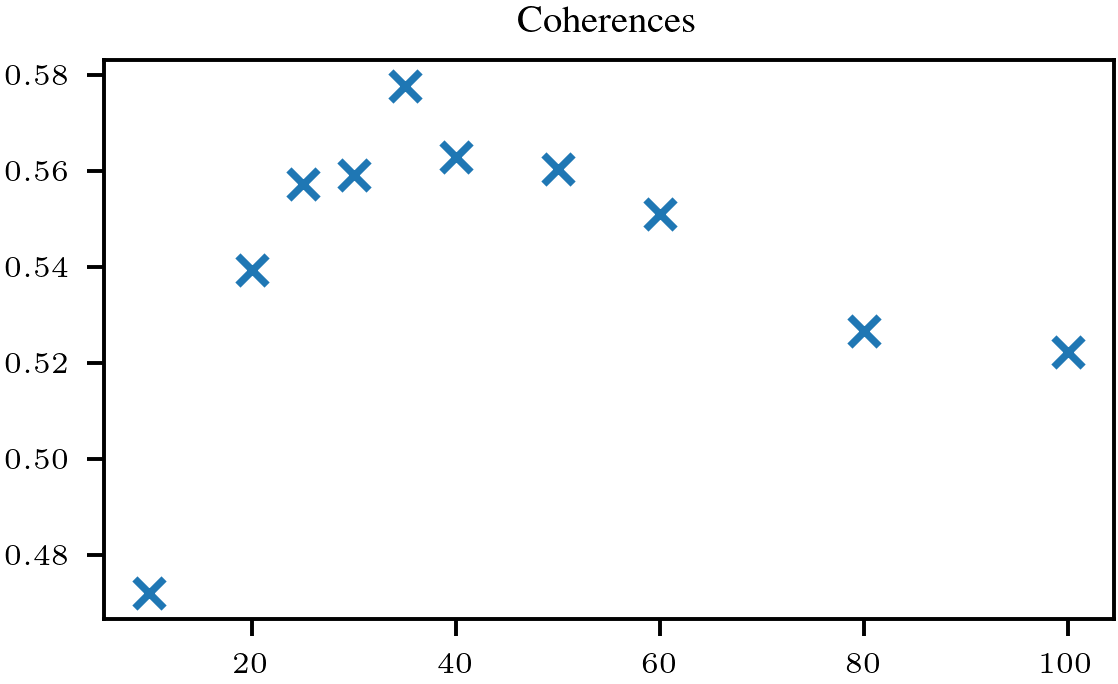

<Figure size 1137.5x703.014 with 0 Axes>

In [52]:
plt.figure()
plt.scatter(stats.index, stats["coherence"], marker="x", label="coherence")
plt.title("Coherences")
plt.figure()
# plt.scatter(stats.index, stats["top_pos"], marker="x", label="coherence")
# plt.title("Top positions")
# plt.figure()
# plt.scatter(stats.index, stats["highest_prob"], marker="x", label="coherence")
# plt.title("Max probs")


In [53]:
n_speeches_n_passes = {}
for (n_topics, n_passes) in dfs_migration.keys(): 
    n_speeches = len(dfs_migration[(n_topics, n_passes)])
    if n_passes not in n_speeches_n_passes: 
        n_speeches_n_passes[n_passes] = []
    
    n_speeches_n_passes[n_passes].append((n_topics, n_speeches))


Text(0.5, 1.0, 'Number of speeches per n_topics')

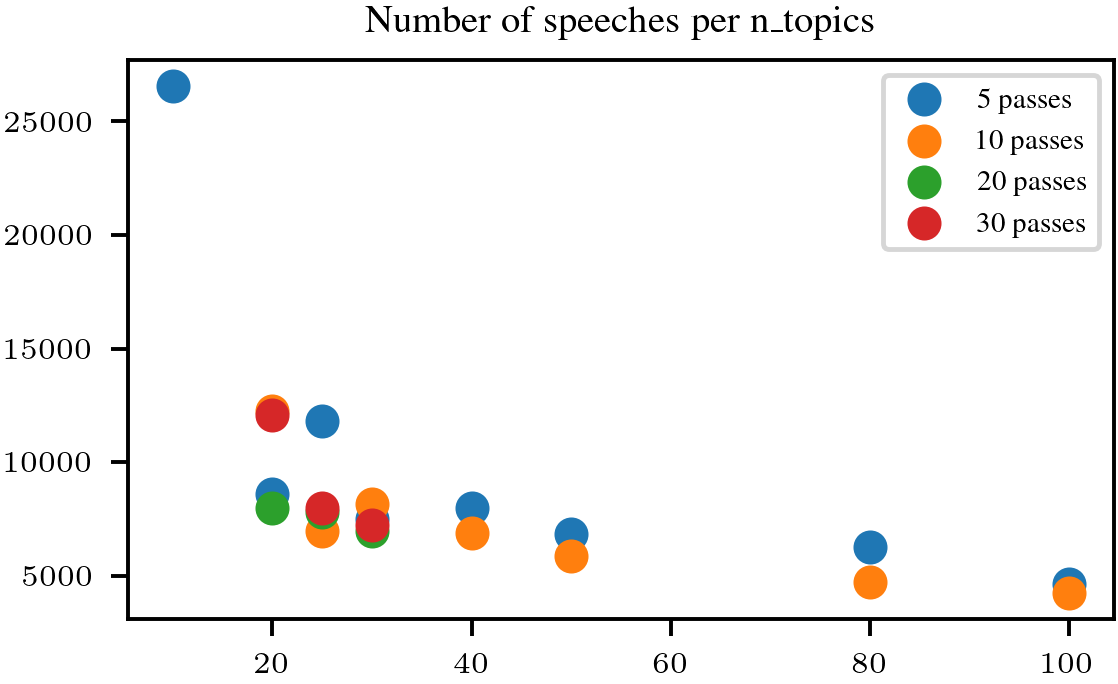

In [54]:
plt.figure()
for n_passes, values in n_speeches_n_passes.items():
    x, y = zip(*values)
    plt.scatter(x, y, label=f"{n_passes} passes", marker="o")
plt.legend()
plt.title("Number of speeches per n_topics")

- 10 topics is infeasible because it is too noisy: suspiciously many speeches 
- for the other models (with n_topics < 40) the number of speeches is very comparable; 
- manual inspection of the models with more than 10,000 speeches revealed a lot of noise => has so many migration speeches because it is not very coherent

In [55]:
final_config = (30, 10)

In [56]:
print_topics(models[final_config], final_config[0])

Topic 0: security, united, common, challenge, world
Topic 1: want, think, commissioner, say, know
Topic 2: budget, fund, financial, euro, billion
Topic 3: worker, transport, sector, fund, globalization
Topic 4: fishing, fishery, sea, water, fish
Topic 5: financial, committee, agency, budget, discharge
Topic 6: development, economic, strategy, growth, investment
Topic 7: human, freedom, democracy, political, medium
Topic 8: law, rule, government, democracy, treaty
Topic 9: tax, company, fraud, money, evasion
Topic 10: woman, gender, equality, man, violence
Topic 11: attack, world, today, victim, terrorist
Topic 12: health, substance, china, scientific, modify
Topic 13: bank, crisis, economic, unemployment, investment
Topic 14: energy, climate, emission, change, gas
Topic 15: agreement, trade, council, protocol, regulation
Topic 16: conflict, peace, humanitarian, international, situation
Topic 17: education, cultural, human, young, training
Topic 18: turkey, germany, minister, german, wa

Topic 19 terms:
  refugee: 0.0348
  border: 0.0301
  migration: 0.0240
  migrant: 0.0174
  asylum: 0.0168
  crisis: 0.0129
  immigration: 0.0094
  solidarity: 0.0083
  external: 0.0080
  mediterranean: 0.0079
Number of speeches in topic 19 (['refugee', 'border', 'migration']) with prob >= 0.3): 8141
Top speeches for topic 19 (['refugee', 'border', 'migration']):

Just passing speeches for topic 19 (['refugee', 'border', 'migration']):



/var/folders/x7/f5pbgh4x4wg5wy434tcjgcc40000gn/T/ipykernel_13084/513441321.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


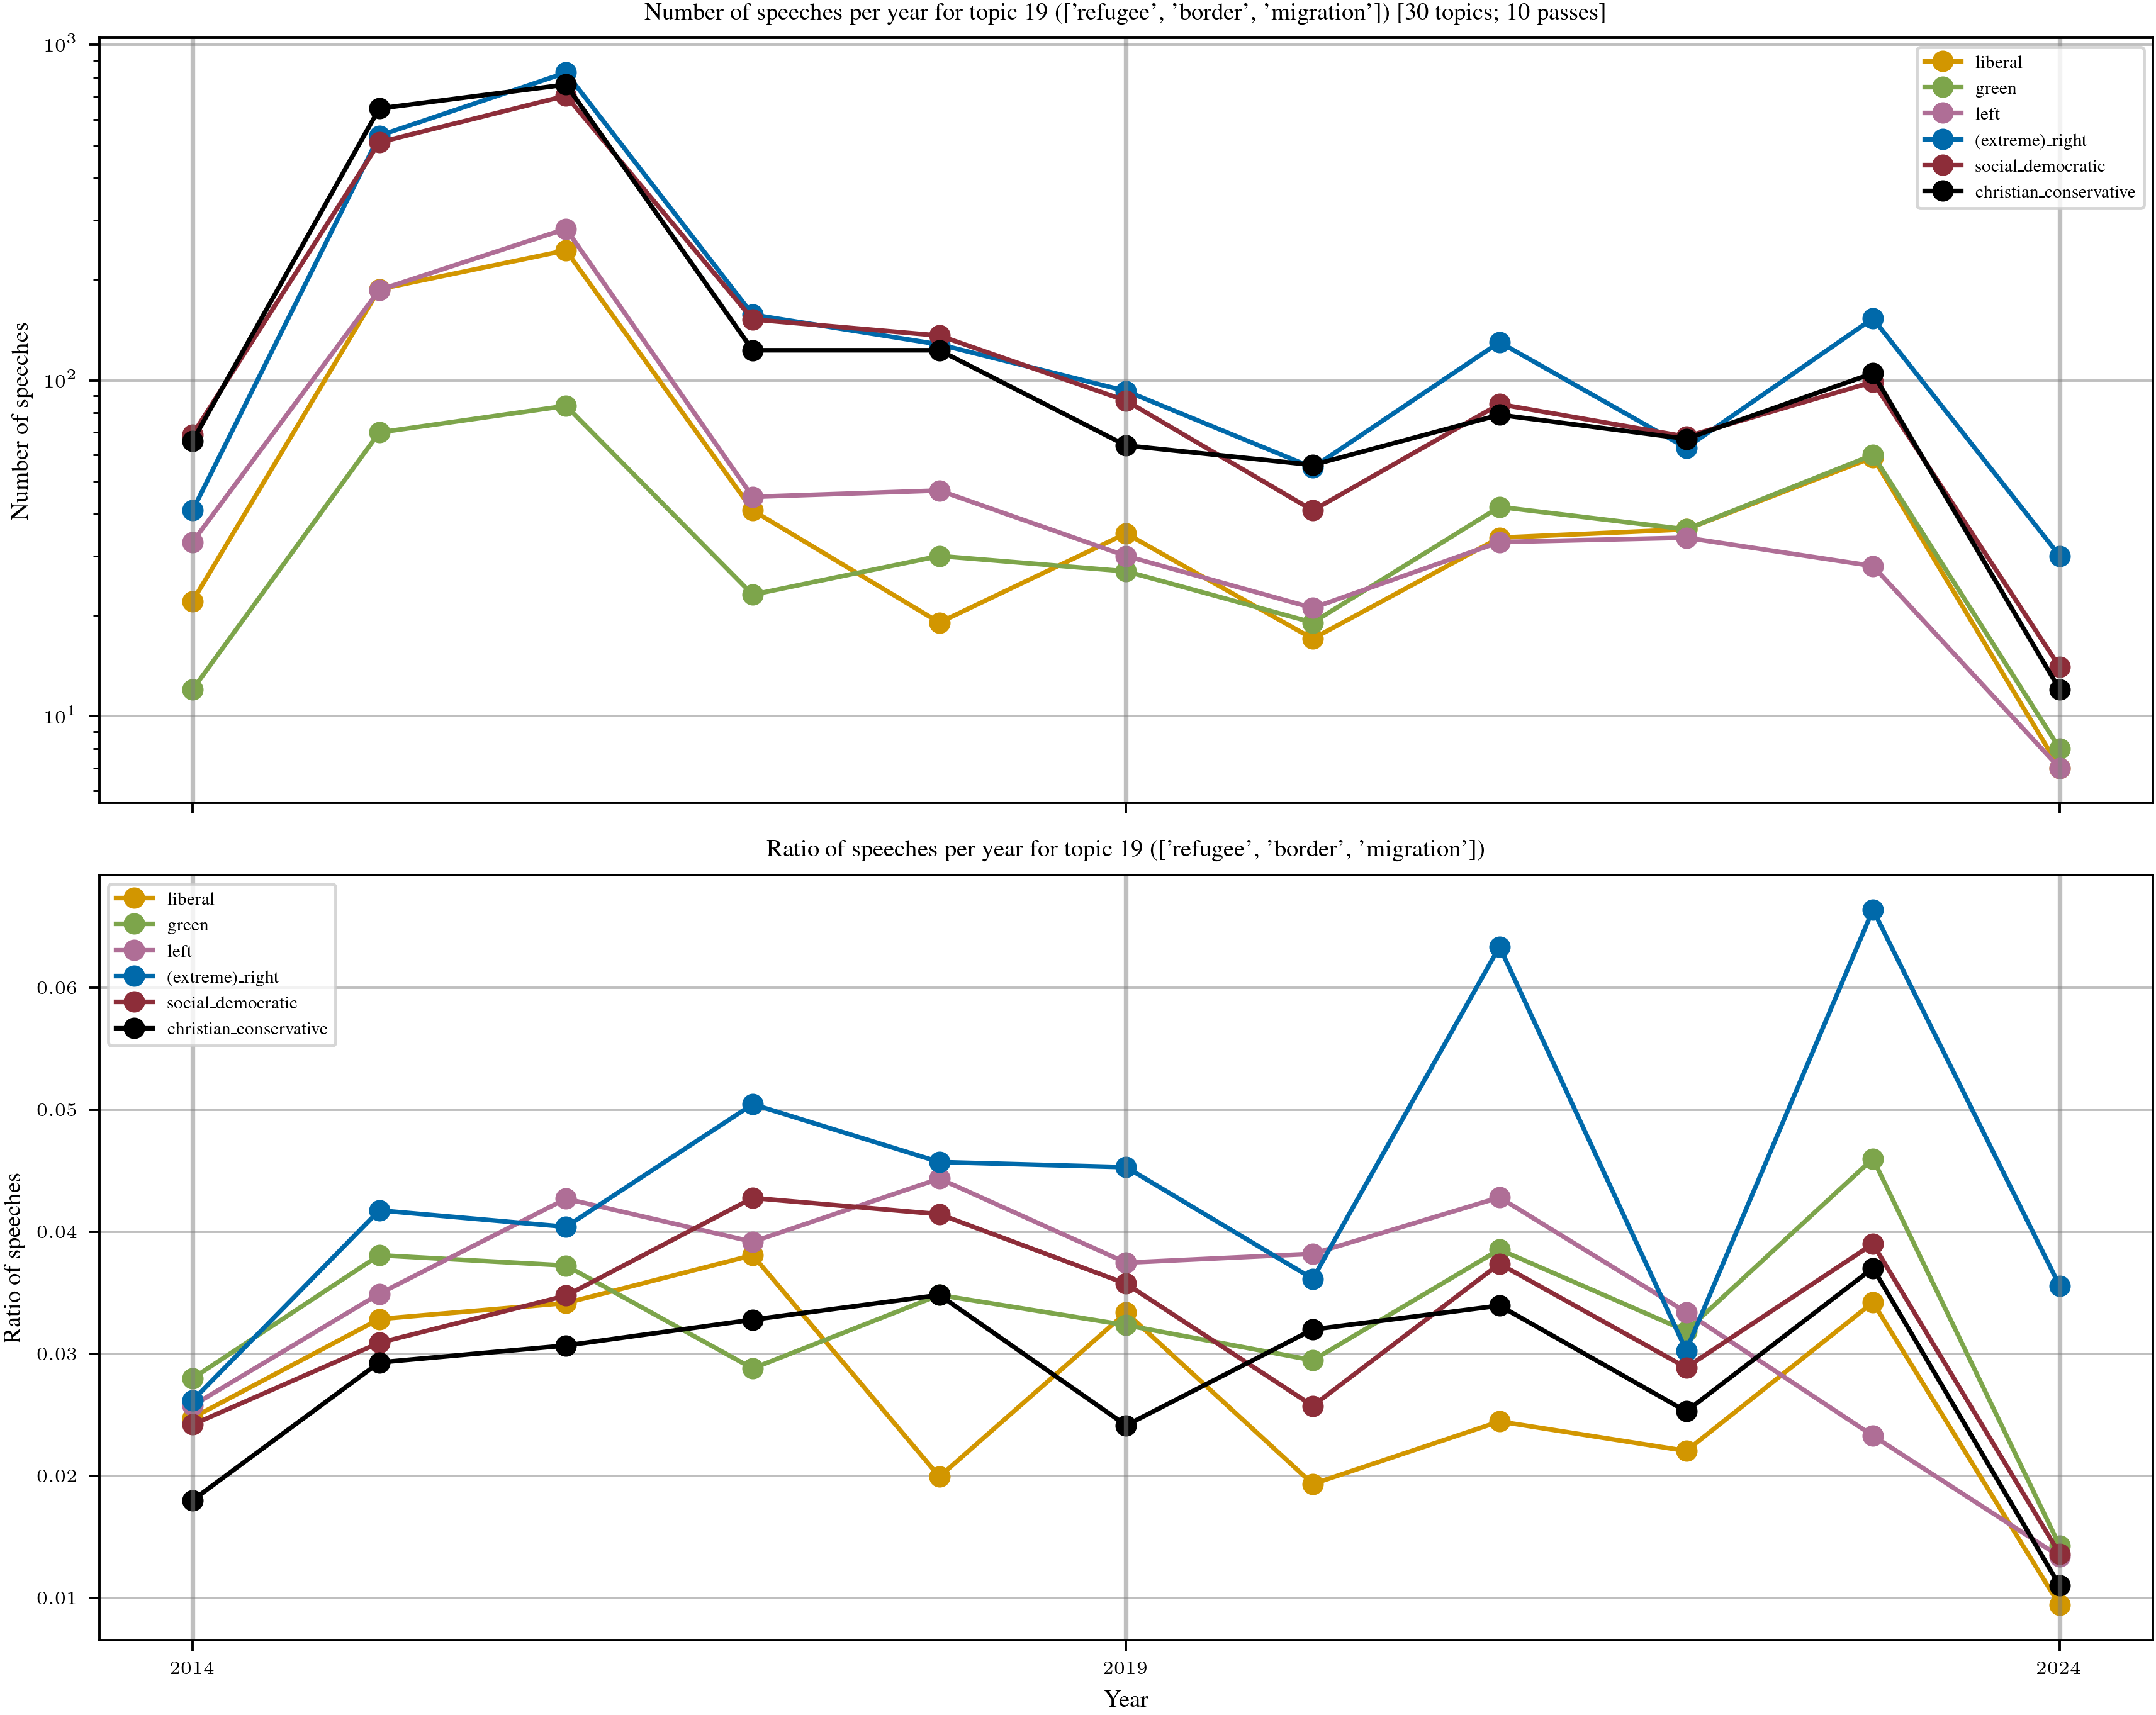

In [59]:
topics_keywords = find_topic_id("migration", models[final_config], final_config[0]) 
if isinstance(topics_keywords, int): 
    explore_topic_id(topics_keywords, models[final_config], dfs[final_config], f"{final_config[0]} topics; {final_config[1]} passes", speech_number=0)